# Feature Selection

In [46]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# In case I need to use my GPU
import os
os.environ['TF_MPS'] = '1'
import tensorflow as tf

# Check if the GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


pd.options.display.max_columns = 50

Num GPUs Available:  1


In [47]:
df = pd.read_csv('Exported Data/DF_from_EDA_for_Feature_Selection.csv')
df.drop('Tail_Number', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6777978 entries, 0 to 6777977
Data columns (total 12 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   Carrier_Name              object
 1   Month                     object
 2   Week_Day                  object
 3   Origin                    object
 4   Destination               object
 5   Dep_Time_Block_Group      object
 6   Arr_Time_Block_Group      object
 7   Distance_Group            int64 
 8   Distance_Miles            int64 
 9   Scheduled_Departure_Time  int64 
 10  Scheduled_Arrival_Time    int64 
 11  Delayed                   int64 
dtypes: int64(5), object(7)
memory usage: 620.5+ MB


### Down Sampling Data to Address Imbalance in Target Variable

In [48]:
# Separate majority and minority classes
df_majority = df[df.Delayed == 0]
df_minority = df[df.Delayed == 1]

# Downsample majority class to match minority class size
df_majority_downsampled = resample(df_majority,
                                    replace=False,  # Sample without replacement
                                    n_samples=len(df_minority),  # Match minority class size
                                    random_state=1)  # Ensure reproducibility

# Combine minority class with downsampled majority class
df_ds = pd.concat([df_minority, df_majority_downsampled])

# Shuffle the resulting dataframe
df_ds = df_ds.sample(frac=1, random_state=1).reset_index(drop=True)

# Verify the new class distribution
print(df_ds['Delayed'].value_counts())

# Verify new dataframe shape
print(df_ds.shape)

0    1371451
1    1371451
Name: Delayed, dtype: int64
(2742902, 12)


### Determining Categorical Variable Cardinality

In [49]:
cat_vars = [
            'Carrier_Name',
            'Month',
            'Week_Day',
            'Origin',
            'Destination',
            'Dep_Time_Block_Group',
            'Arr_Time_Block_Group'
]

In [50]:
df_ds[cat_vars].nunique()

Carrier_Name             15
Month                    12
Week_Day                  7
Origin                  347
Destination             348
Dep_Time_Block_Group      6
Arr_Time_Block_Group      6
dtype: int64

## Correlation Analysis of Categorical Features to Target

                               Chi2  p-value  Cramér's V
Carrier_Name           54034.588064      0.0    0.140356
Month                  54771.014104      0.0    0.141309
Week_Day                9364.769782      0.0    0.058431
Origin                 38259.547054      0.0    0.118104
Destination            27207.075064      0.0    0.099595
Dep_Time_Block_Group  113334.006113      0.0    0.203271
Arr_Time_Block_Group   97816.330879      0.0    0.188843


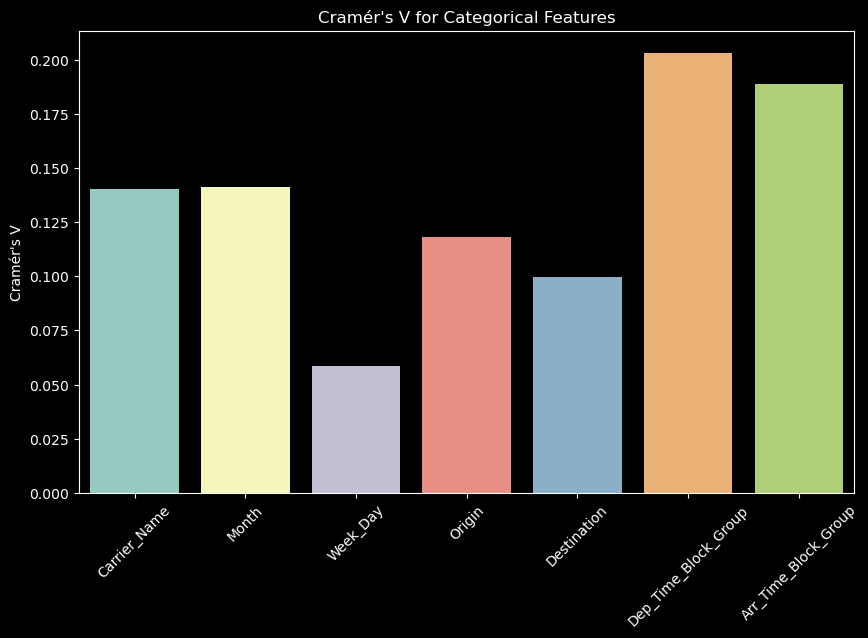

In [51]:
# List of categorical features
categorical_features = [
                        'Carrier_Name',
                        'Month',
                        'Week_Day',
                        'Origin',
                        'Destination',
                        'Dep_Time_Block_Group',
                        'Arr_Time_Block_Group'
                        ]

# Target variable
target = 'Delayed'

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Dictionary to store results
results = {}

# Chi-square test and Cramér's V calculation
for feature in categorical_features:
    # Create a contingency table
    contingency_table = pd.crosstab(df_ds[feature], df_ds[target])

    # Perform Chi-square test
    chi2, p, dof, ex = chi2_contingency(contingency_table)

    # Calculate Cramér's V
    cramers_v_value = cramers_v(contingency_table.values)

    # Store results
    results[feature] = {'Chi2': chi2, 'p-value': p, 'Cramér\'s V': cramers_v_value}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Display results
print(results_df)

# Plot the Cramér's V values
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='Cramér\'s V', data=results_df)
plt.xticks(rotation=45)
plt.title('Cramér\'s V for Categorical Features')
plt.show()

## Correlation Analysis of Numerical Features to Target

                          Pearson Correlation
Scheduled_Arrival_Time               0.154839
Scheduled_Departure_Time             0.197662
Distance_Miles                       0.039145


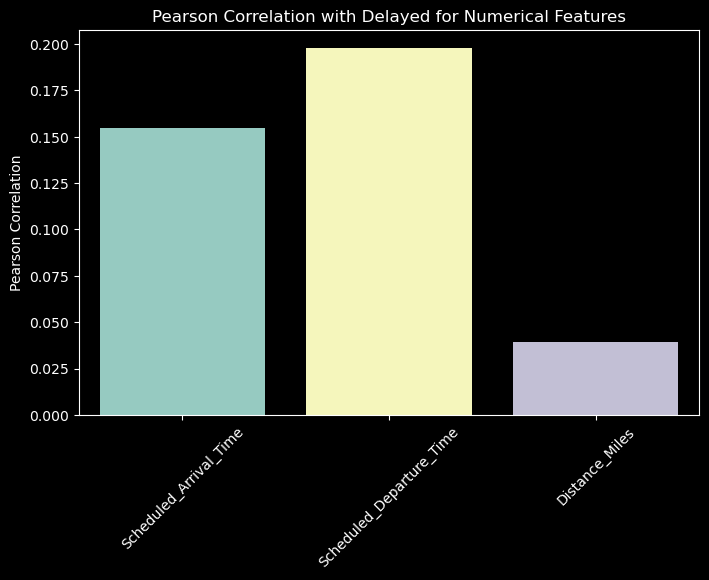

In [52]:
import scipy.stats as stats

# Function to calculate Pearson correlation
def pearson_correlation(x, y):
    correlation, _ = stats.pearsonr(x, y)
    return correlation

# List of numerical features
numerical_features = ['Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Distance_Miles']

# Dictionary to store results
results_numerical = {}

# Calculate Pearson correlation and store results
for feature in numerical_features:
    correlation = pearson_correlation(df_ds[feature], df_ds[target])
    results_numerical[feature] = {'Pearson Correlation': correlation}

# Convert results to DataFrame
results_numerical_df = pd.DataFrame(results_numerical).T

# Display results for numerical features
print(results_numerical_df)

# Plot the Pearson correlation values
plt.figure(figsize=(8, 5))
sns.barplot(x=results_numerical_df.index, y='Pearson Correlation', data=results_numerical_df)
plt.xticks(rotation=45)
plt.title('Pearson Correlation with Delayed for Numerical Features')
plt.show()


## Evaluating Feature Importance

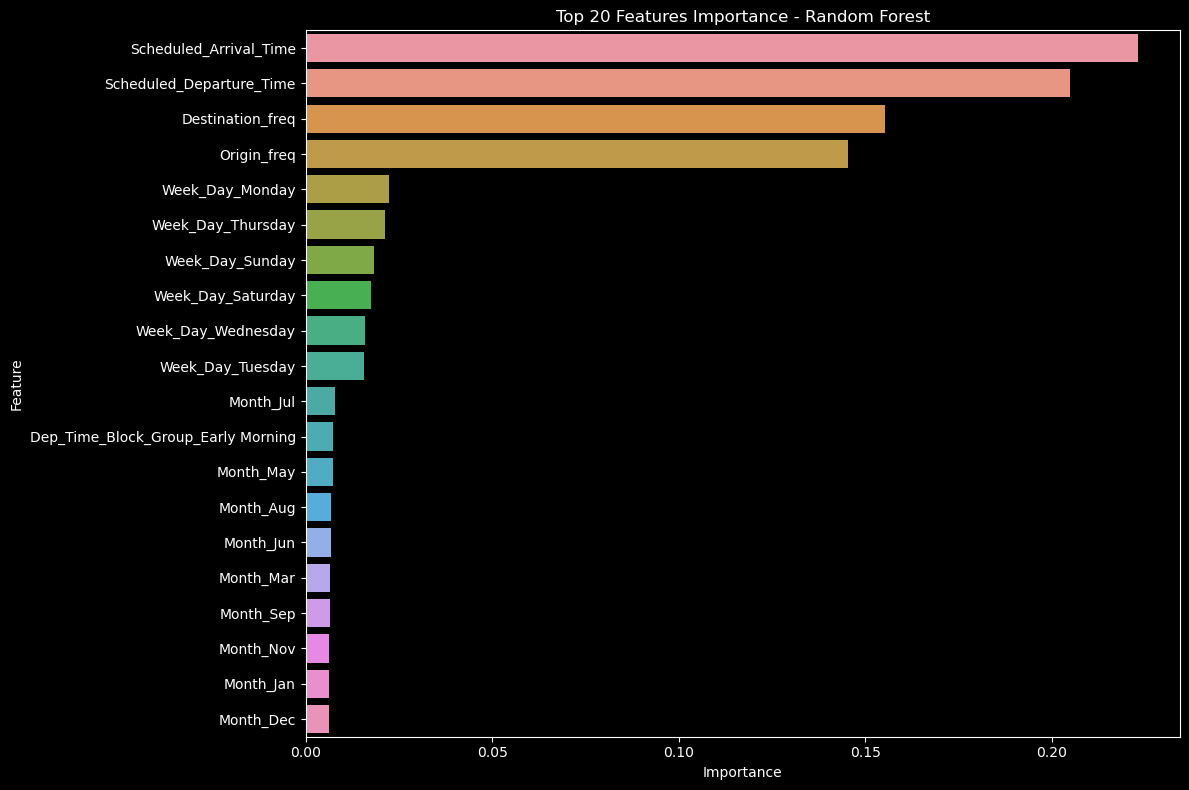

In [53]:
# Encode categorical variables and prepare features
df_encoded = pd.get_dummies(df_ds[['Carrier_Name', 'Month', 'Week_Day', 'Dep_Time_Block_Group', 'Arr_Time_Block_Group']], drop_first=True)
for col in ['Origin', 'Destination']:
    freq_encoding = df_ds[col].value_counts().to_dict()
    df_encoded[col + '_freq'] = df_ds[col].map(freq_encoding)

# Include numerical variables
df_encoded = pd.concat([df_encoded, df_ds[['Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Delayed']]], axis=1)

# Separate features and target variable
X = df_encoded.drop('Delayed', axis=1)
y = df_encoded['Delayed']

from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Create DataFrame to store feature importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# Plotting the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))  
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features Importance - Random Forest')
plt.tight_layout()
plt.show()

## Export Down Sampled DF for Model Selection

In [54]:
df_ds.to_csv('Exported Data/DF_from_Feature_Sel_for_Model_Sel.csv', index=False)